## Bước 1: Tiền xử lý dữ liệu
#### Import các thư viện cần thiết cho việc xử lý dữ liệu

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from PIL import Image

print('Finish importing libraries')

Finish importing libraries


#### Chuyển đổi annotations COCO format thành mask images để chuẩn bị dữ liệu cho việc training U-Net segmentation model

In [2]:
# Đường dẫn dataset gốc
BASE_DIR = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation'
# Thư mục output
MASKS_DIR = "/kaggle/working/masks"
os.makedirs(MASKS_DIR, exist_ok=True)

#### Hàm sinh mask cho 3 tập train, test và valid

In [3]:
def generate_masks(split):
    """
    split: "train", "test", "valid"
    """
    input_dir = os.path.join(BASE_DIR, split)
    ann_file = os.path.join(input_dir, "_annotations.coco.json")
    masks_dir = os.path.join(MASKS_DIR, split)
    os.makedirs(masks_dir, exist_ok=True)

    coco = COCO(ann_file)
    img_ids = coco.getImgIds()

    print(f"Processing {split}: {len(img_ids)} images")

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_name = img_info['file_name']
        height, width = img_info["height"], img_info["width"]

        # Mask trắng đen
        mask = np.zeros((height, width), dtype=np.uint8)

        # Annotation của ảnh 
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            m = coco.annToMask(ann)
            mask = np.maximum(mask, m * 255)  # cộng dồn các tumor

        # Lưu mask
        mask_name = os.path.splitext(img_name)[0] + "_mask.png"
        mask_path = os.path.join(masks_dir, mask_name)
        Image.fromarray(mask).save(mask_path)

    print(f"Done {split}, masks saved to {masks_dir}")

In [4]:
# Tạo mask cho cả 3 folder
for split in ["train", "test", "valid"]:
    generate_masks(split)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Processing train: 1502 images
Done train, masks saved to /kaggle/working/masks/train
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Processing test: 215 images
Done test, masks saved to /kaggle/working/masks/test
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Processing valid: 429 images
Done valid, masks saved to /kaggle/working/masks/valid


#### Hàm show ảnh từ dataset và mask tương ứng của nó

In [5]:
def show_random_pair(split="train", overlay=True):
    """
    split: "train", "test", "valid"
    overlay: nếu True thì hiển thị thêm ảnh chồng (MRI + mask)
    """
    img_dir = os.path.join(BASE_DIR, split)
    mask_dir = os.path.join(MASKS_DIR, split)

    # Lấy danh sách ảnh gốc
    img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")]
    
    # Random chọn 1 ảnh
    img_name = random.choice(img_files)

    # Đọc ảnh gốc
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # Đọc mask tương ứng
    mask_name = os.path.splitext(img_name)[0] + "_mask.png"
    mask_path = os.path.join(mask_dir, mask_name)
    mask = Image.open(mask_path).convert("L")
    mask_np = np.array(mask)

    # Tạo overlay (mask màu đỏ trong suốt)
    overlay_img = img_np.copy()
    overlay_img[mask_np > 0] = [255, 0, 0]  # tô đỏ vùng tumor
    blended = (0.6 * img_np + 0.4 * overlay_img).astype(np.uint8)

    # Vẽ ảnh
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3 if overlay else 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3 if overlay else 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    if overlay:
        plt.subplot(1, 3, 3)
        plt.imshow(blended)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


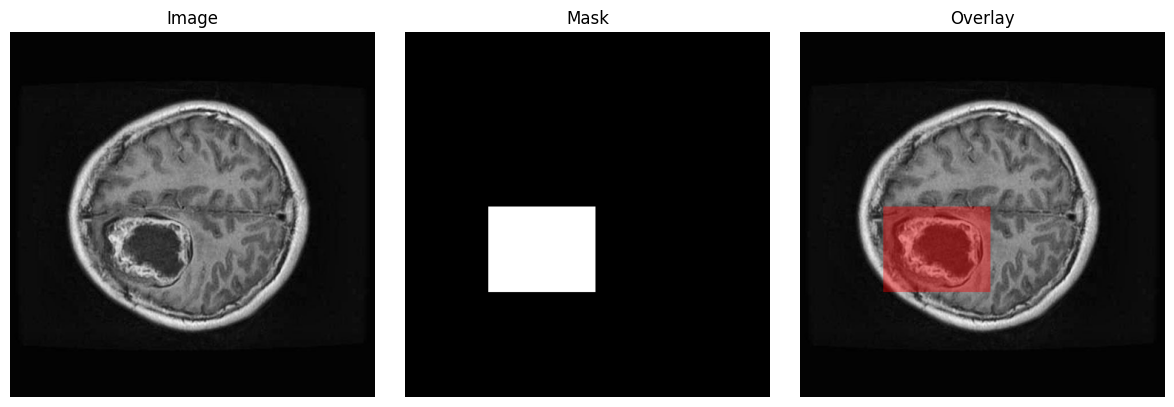

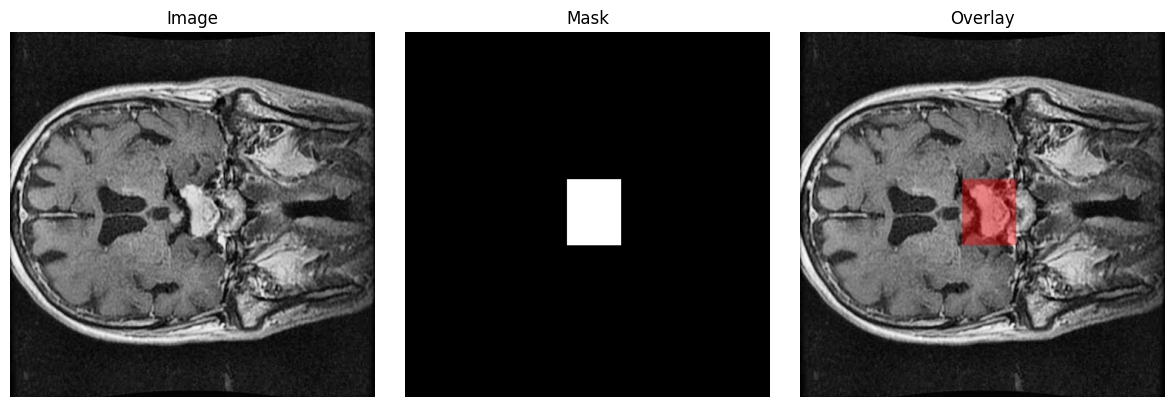

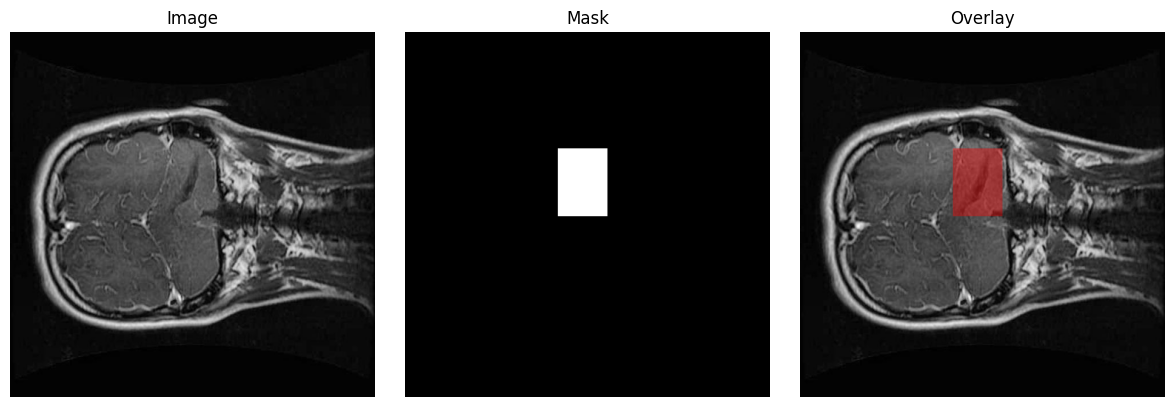

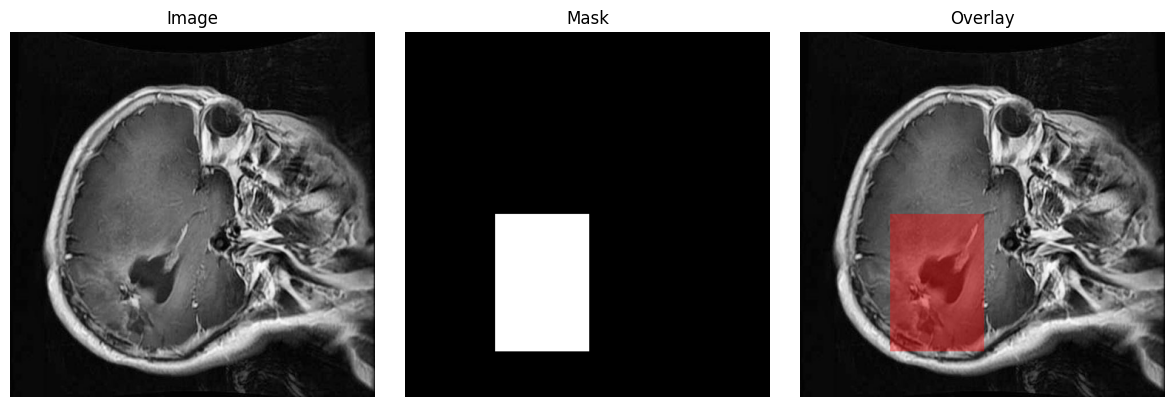

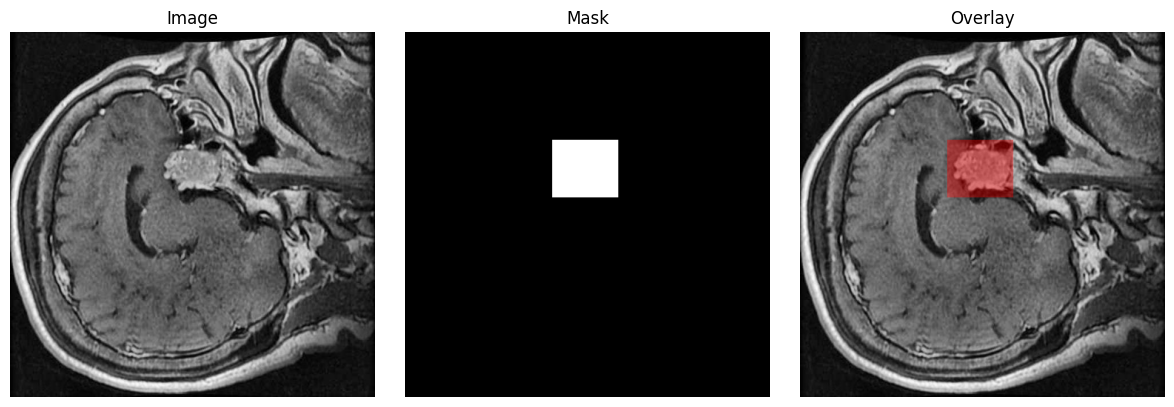

In [6]:
# Ví dụ: random 5 cặp trong folder train + overlay
for _ in range(5):
    show_random_pair(split="train", overlay=True)

## Bước 2: Tạo và huấn luyện mô hình Unet

#### Tải thư viện segmentation_models chứa các mô hình đã được build sẵn như Unet, Unet++

In [7]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.6 MB/s eta 0:00:000:00:0100:01
  Attempting uninsta

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.amp import GradScaler

import torchvision.transforms.functional as TF

import segmentation_models_pytorch as smp

print('Finish importing libraries')

Finish importing libraries


In [9]:
# Các siêu tham số và hằng số cho việc huấn luyện
IMG_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 40
LR = 1e-4
NUM_WORKERS = 4
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [10]:
# Utils: Transform
def resize_pair(img_pil, mask_pil, size=IMG_SIZE):
    # img: bilinear | mask: nearest
    img = TF.resize(img_pil, [size, size], interpolation=TF.InterpolationMode.BILINEAR)
    mask = TF.resize(mask_pil, [size, size], interpolation=TF.InterpolationMode.NEAREST)
    return img, mask

def to_tensor_pair(img_pil, mask_pil):
    # img -> [0,1], CHW float32 | mask -> {0,1}, 1xHxW float32
    img = TF.to_tensor(img_pil)  # (3,H,W)
    mask = torch.from_numpy((np.array(mask_pil) > 0).astype(np.float32))  # (H,W)
    mask = mask.unsqueeze(0)  # (1,H,W)
    return img, mask

def random_augment(img_pil, mask_pil, p_hflip=0.5, p_vflip=0.2):
    # Augmentation đơn giản bằng cách lật ngang hoặc lật dọc một vài ảnh
    if random.random() < p_hflip:
        img_pil = TF.hflip(img_pil)
        mask_pil = TF.hflip(mask_pil)
    if random.random() < p_vflip:
        img_pil = TF.vflip(img_pil)
        mask_pil = TF.vflip(mask_pil)
    return img_pil, mask_pil


In [11]:
# Khởi tạo Dataset 
class TumorSegDataset(Dataset):
    def __init__(self, split="train", augment=False):
        self.split = split
        self.img_dir = os.path.join(BASE_DIR, split)
        self.mask_dir = os.path.join(MASKS_DIR, split)

        self.img_files = [f for f in os.listdir(self.img_dir)
                          if f.lower().endswith((".jpg", ".png")) and not f.startswith("_")]
        self.img_files.sort()
        self.augment = augment

        # kiểm tra mask tồn tại
        missing = []
        for f in self.img_files:
            mask_name = os.path.splitext(f)[0] + "_mask.png"
            if not os.path.exists(os.path.join(self.mask_dir, mask_name)):
                missing.append(mask_name)
        if missing:
            print(f"[WARN] Missing {len(missing)} masks in {self.mask_dir}. Example: {missing[:5]}")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        f = self.img_files[idx]
        img_path = os.path.join(self.img_dir, f)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(f)[0] + "_mask.png")

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # augment (train)
        if self.augment:
            img, mask = random_augment(img, mask)

        # resize
        img, mask = resize_pair(img, mask, IMG_SIZE)

        # to tensor
        img, mask = to_tensor_pair(img, mask)

        # normalize (ImageNet-like)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = (img - mean) / std

        return img, mask

In [12]:
# Tạo dataset cho train, test và valid
train_dataset = TumorSegDataset("train", augment=True)
val_dataset = TumorSegDataset("valid", augment=False)
test_dataset = TumorSegDataset("test", augment=False)
# Tạo dataloader cho train, test và valid
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

#### Khởi tạo kiến trúc và huấn luyện mô hình Unet

In [33]:
# Model Unet từ smp
model = smp.Unet(
    encoder_name='resnet34',     # backbone resnet34
    encoder_weights='imagenet',  # pretrained imagenet
    in_channels=3,               # RGB
    classes=1,                   # binary mask           
).to(DEVICE)

# Loss và Optimizer
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, epsilon=1e-7):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + epsilon
    den = pred.sum() + target.sum() + epsilon
    return 1 - num/den

def combined_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)
scaler = GradScaler('cuda')

In [34]:
# Metrics
def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    pred = (torch.sigmoid(pred) > threshold).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + epsilon)/(union + epsilon)

def dice_score(pred, target, threshold=0.5, epsilon=1e-7):
    pred = (torch.sigmoid(pred) > threshold).float()
    inter = (pred * target).sum()
    return (2 * inter + epsilon) / (pred.sum() + target.sum() + epsilon)

In [35]:
# Train model
def train_one_epoch(loader):
    model.train()
    total_loss = 0
    for imgs,masks in loader:
        imgs,masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        
        logits = model(imgs)
        loss = dice_loss(logits, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

In [36]:
# Validate model
def validate(loader):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    with torch.no_grad():
        for imgs,masks in loader:
            imgs,masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)
            loss = dice_loss(logits, masks)
            total_loss += loss.item() * imgs.size(0)
            total_iou += iou_score(logits,masks).item() * imgs.size(0)
            total_dice += dice_score(logits,masks).item() * imgs.size(0)
    n = len(loader.dataset)
    return total_loss/n, total_iou/n, total_dice/n

In [37]:
# Training
best_dice = 0
patience = 5
counter = 0
real_epochs = EPOCHS
train_losses, val_losses, val_ious, val_dices = [], [], [], []
test_losses, test_ious, test_dices = [], [], []

for epoch in range(EPOCHS):
    tr_loss = train_one_epoch(train_loader)
    v_loss, v_iou, v_dice = validate(val_loader)
    t_loss, t_iou, t_dice = validate(test_loader)

    # lr_scheduler
    lr_scheduler.step(v_dice)
    
    train_losses.append(tr_loss)
    val_losses.append(v_loss)
    val_ious.append(v_iou)
    val_dices.append(v_dice)
    test_losses.append(t_loss)
    test_ious.append(t_iou)
    test_dices.append(t_dice)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss {tr_loss:.4f} | "
          f"Val loss {v_loss:.4f} | Val IoU {v_iou:.4f} | Val Dice {v_dice:.4f} | "
          f"Test loss {t_loss:.4f} | Test IoU {t_iou:.4f} | Test Dice {t_dice:.4f}")

    # Save checkpoint
    if v_dice > best_dice:
        best_dice = v_dice
        torch.save(model.state_dict(), "/kaggle/working/unet_best.pth")
        counter = 0
    else:
        counter += 1

    # Early stopping
    if counter >= patience:
        real_epochs = epoch + 1
        print("Early stopping triggered!")
        break

print(f"Best dice: {best_dice:.4f}")

Epoch 1/40 | Train loss 0.8737 | Val loss 0.8588 | Val IoU 0.1083 | Val Dice 0.1950 | Test loss 0.8591 | Test IoU 0.1074 | Test Dice 0.1934
Epoch 2/40 | Train loss 0.8117 | Val loss 0.7822 | Val IoU 0.2997 | Val Dice 0.4597 | Test loss 0.7877 | Test IoU 0.2797 | Test Dice 0.4365
Epoch 3/40 | Train loss 0.7679 | Val loss 0.7494 | Val IoU 0.4177 | Val Dice 0.5884 | Test loss 0.7545 | Test IoU 0.3912 | Test Dice 0.5611
Epoch 4/40 | Train loss 0.7331 | Val loss 0.7251 | Val IoU 0.4769 | Val Dice 0.6454 | Test loss 0.7304 | Test IoU 0.4416 | Test Dice 0.6117
Epoch 5/40 | Train loss 0.6986 | Val loss 0.7028 | Val IoU 0.5157 | Val Dice 0.6785 | Test loss 0.7086 | Test IoU 0.4843 | Test Dice 0.6516
Epoch 6/40 | Train loss 0.6622 | Val loss 0.6642 | Val IoU 0.5461 | Val Dice 0.7058 | Test loss 0.6707 | Test IoU 0.5172 | Test Dice 0.6802
Epoch 7/40 | Train loss 0.6197 | Val loss 0.6267 | Val IoU 0.5868 | Val Dice 0.7388 | Test loss 0.6349 | Test IoU 0.5583 | Test Dice 0.7152
Epoch 8/40 | Train l

## Bước 3: Visualize quá trình huấn luyện và hiển thị dự đoán của mô hình

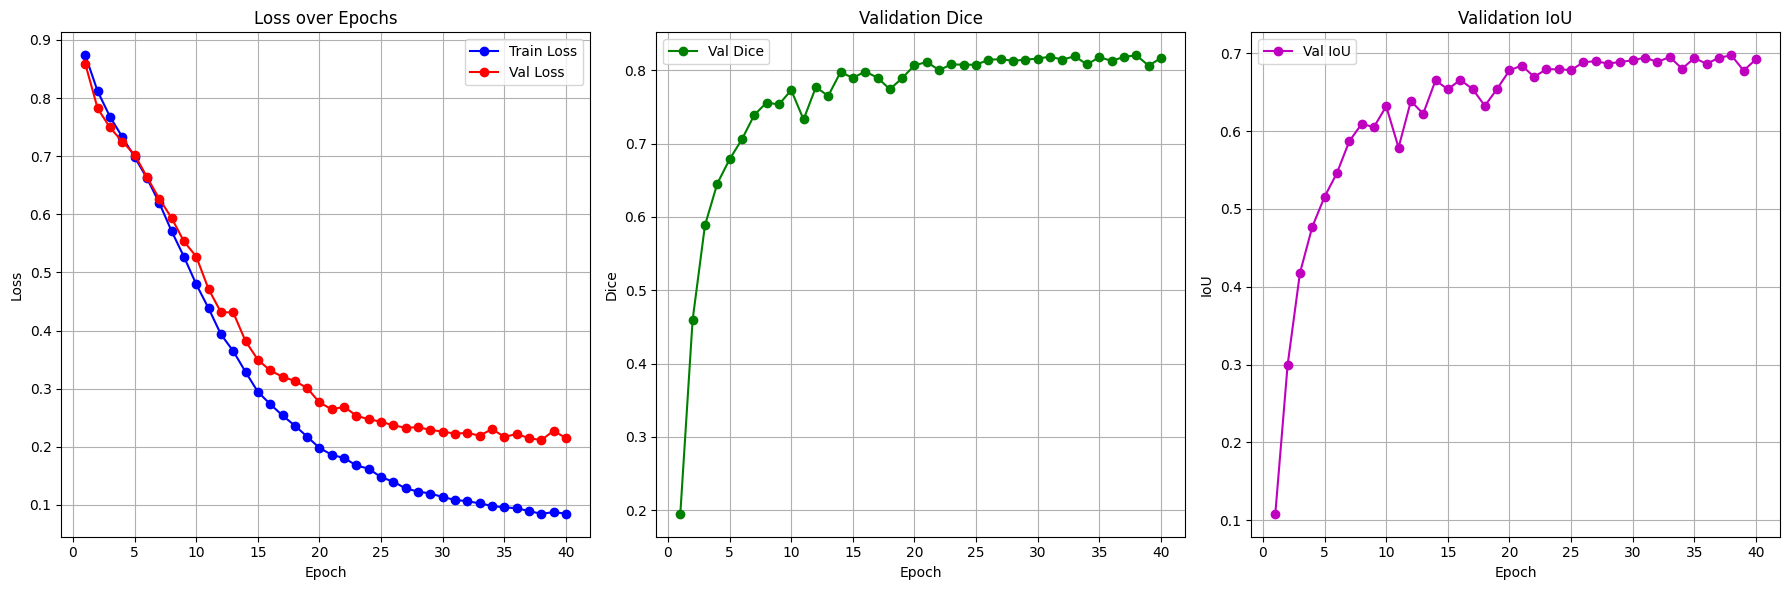

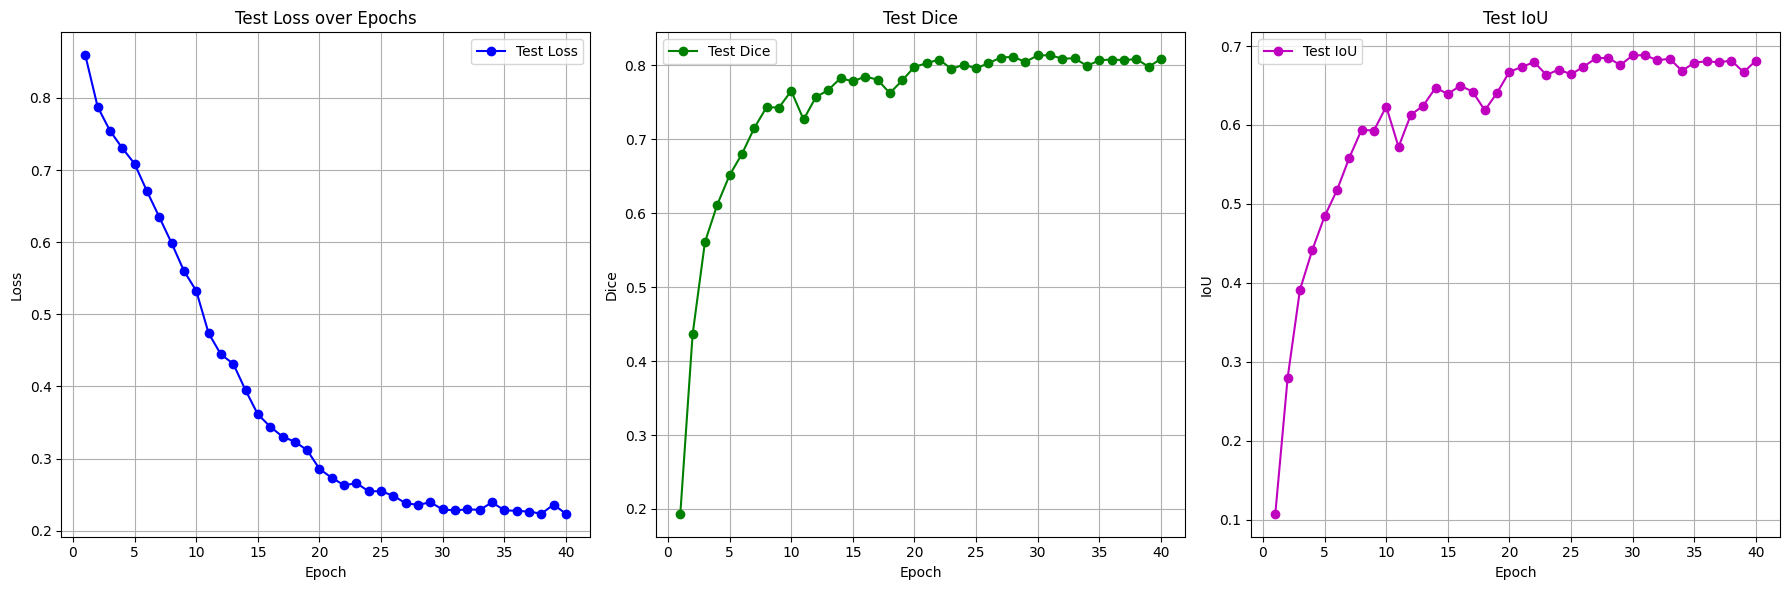

In [51]:
# Visualize quá trình huấn luyện
def plot_training(train_losses, val_losses, val_dices, val_ious):
    epochs = [epoch for epoch in range(1, real_epochs + 1)]
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,2)
    plt.plot(epochs, val_dices, 'go-', label='Val Dice')
    plt.title("Validation Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(epochs, val_ious, 'mo-', label='Val IoU')
    plt.title("Validation IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    # Save figure
    plt.savefig("/kaggle/working/train_fig.png")
    plt.show()

    
    
# Visualize preformance của model trên tập test
def plot_test(test_losses, test_dices, test_ious):
    epochs = [epoch for epoch in range(1, real_epochs + 1)]
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.plot(epochs, test_losses, 'bo-', label='Test Loss')
    plt.title("Test Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,2)
    plt.plot(epochs, test_dices, 'go-', label='Test Dice')
    plt.title("Test Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(epochs, test_ious, 'mo-', label='Test IoU')
    plt.title("Test IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    # Save figure
    plt.savefig("/kaggle/working/test_fig.png")
    plt.show()
    
# Chạy hàm visualize
plot_training(train_losses, val_losses, val_dices, val_ious)
plot_test(test_losses, test_dices, test_ious)

In [52]:
def denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Denormalize ảnh tensor (C,H,W) về [0,255]."""
    image = image.cpu().numpy()
    image = image.transpose(1,2,0)  # (H,W,C)
    image = (image * std + mean)    # undo normalization
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    return image
    
def show_prediction(model, dataset, idx=None, threshold=0.5, save_img=False, output_dir=None):
    """
    Hiển thị ảnh gốc (denormalized) với mask GT (đỏ) và Prediction (xanh).
    """
    # Chọn ảnh
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]  # image: Tensor (C,H,W), mask: Tensor

    # Chuẩn bị tensor cho model
    img_tensor = image.unsqueeze(0).to(DEVICE)  # (1,C,H,W)
    
    # Denormalize ảnh để hiển thị
    img_np = denormalize(image)  # (H,W,C)

    # Chuẩn bị mask GT (ép về H,W)
    mask = mask.cpu().numpy()
    mask = np.squeeze(mask)   # (H,W)

    # Predict (ép về H,W)
    with torch.no_grad():
        pred_mask = model.predict(img_tensor)
    pred_mask = (pred_mask.squeeze().cpu().numpy() > threshold).astype(np.uint8)  # (H,W)

    # Copy ảnh gốc để tô màu
    gt = img_np.copy()
    pred = img_np.copy()

    # Tô màu (chỉ vùng mask được thay đổi)
    gt[mask > 0] = [255, 0, 0]       # GT: đỏ
    pred[pred_mask > 0] = [0, 255, 0]  # Prediction: xanh lá
    # Làm mờ vùng được đánh dấu
    gt_blended = (0.6 * img_np + 0.4 * gt).astype(np.uint8)
    pred_blended = (0.6 * img_np + 0.4 * pred).astype(np.uint8)
    
    # Hiển thị
    plt.figure(figsize=(18, 6))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title(f"Original with index {idx}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_blended)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_blended)
    plt.title("Prediction")
    plt.axis("off")

    if save_img and output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        save_path = os.path.join(output_dir, f"img{idx}.png")
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


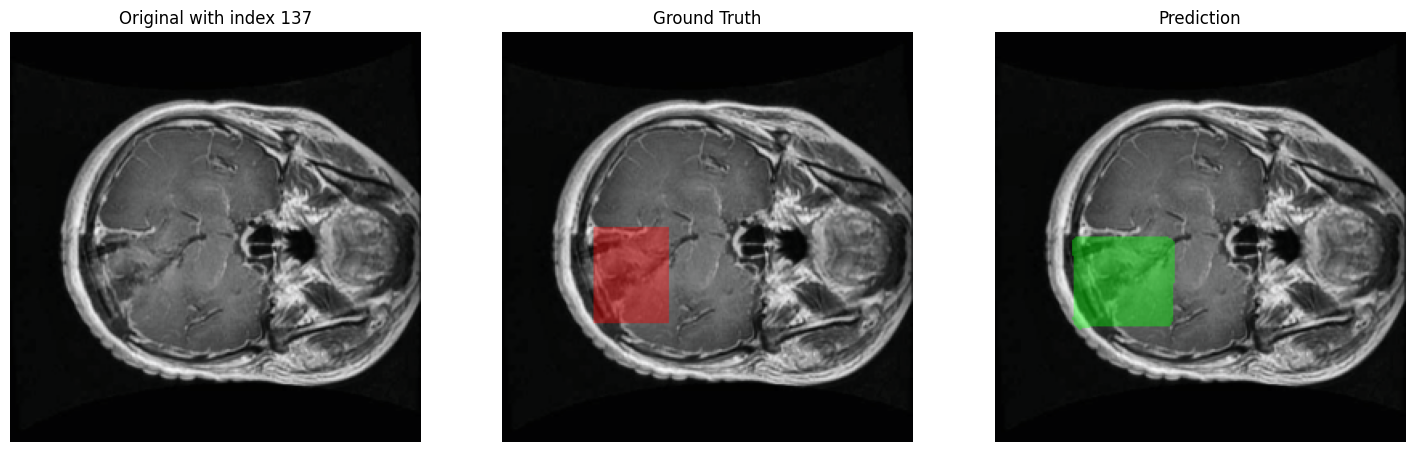

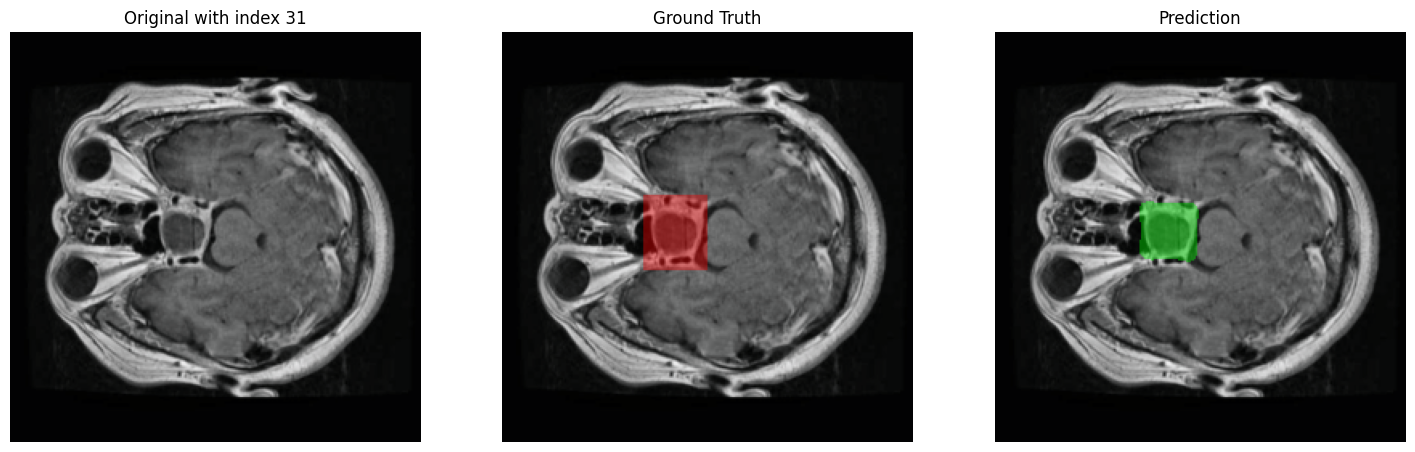

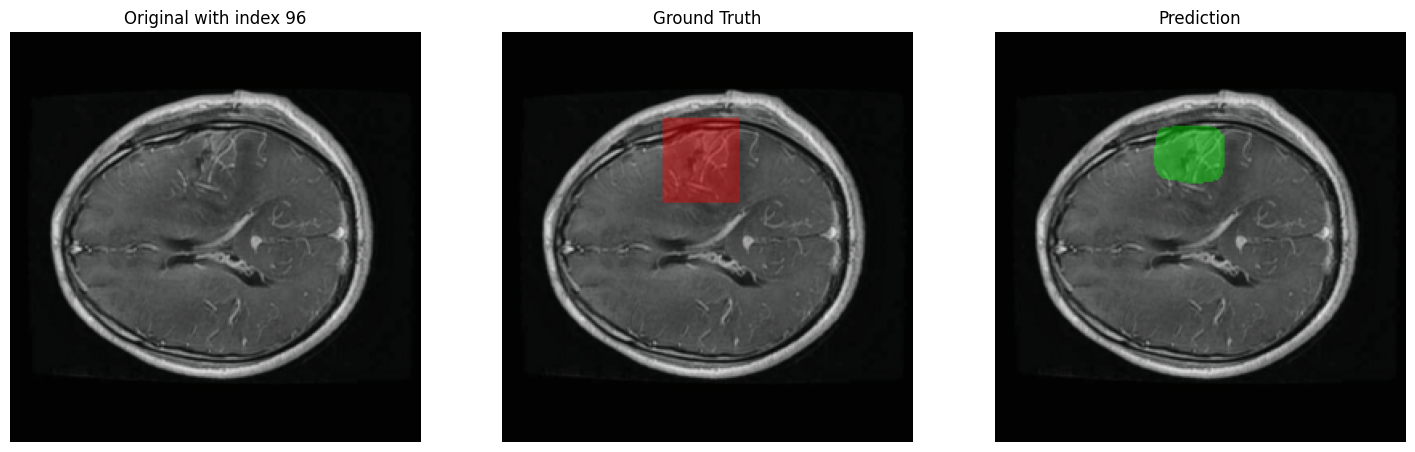

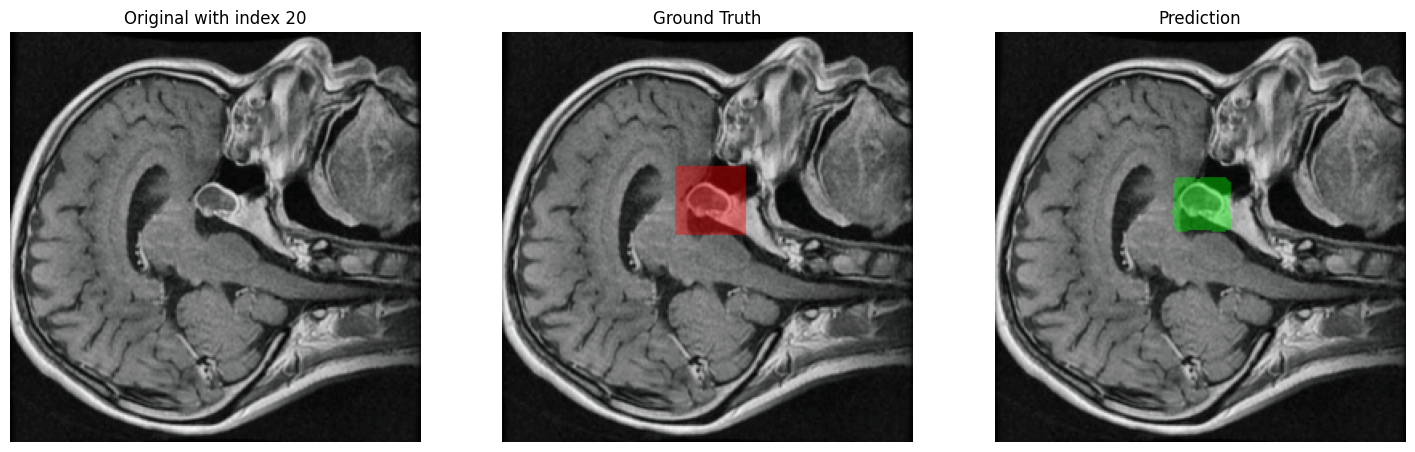

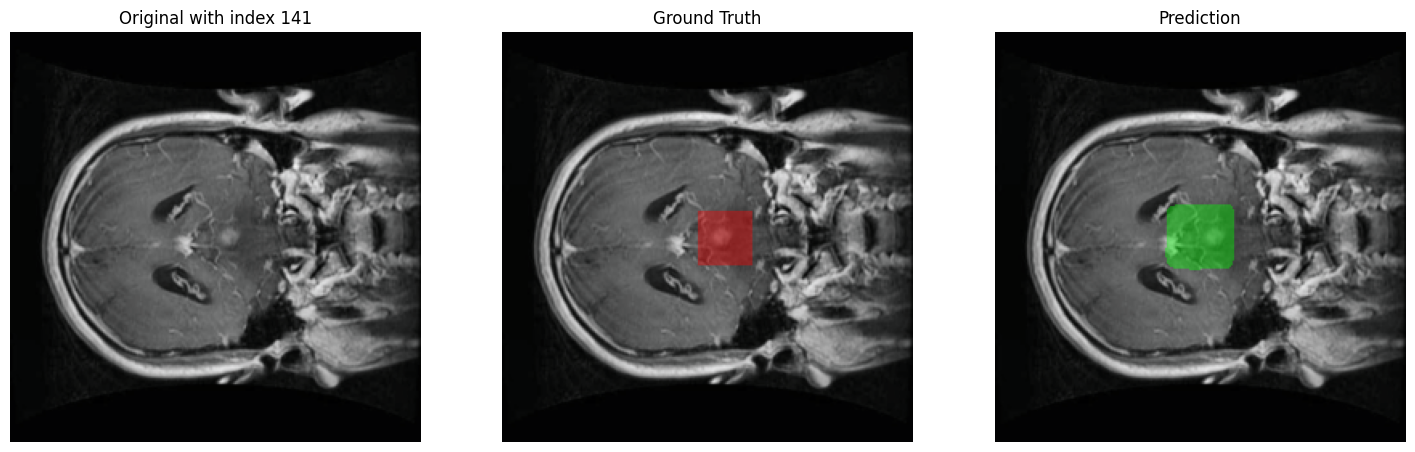

In [53]:
for _ in range(5):
    show_prediction(model=model, dataset=test_dataset)

## Bước 4: Load thử pretrained model và dự đoán

In [54]:
pretrained_model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,                      
)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load mô hình 
pretrained_model.load_state_dict(torch.load("/kaggle/working/unet_best.pth", map_location=device))
pretrained_model.to(device)
pretrained_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

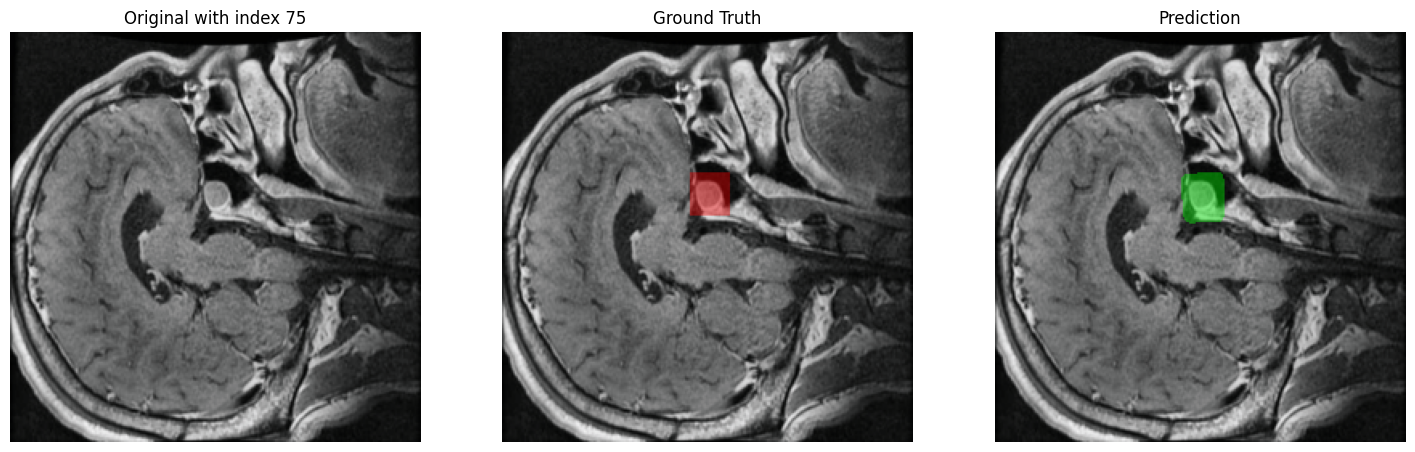

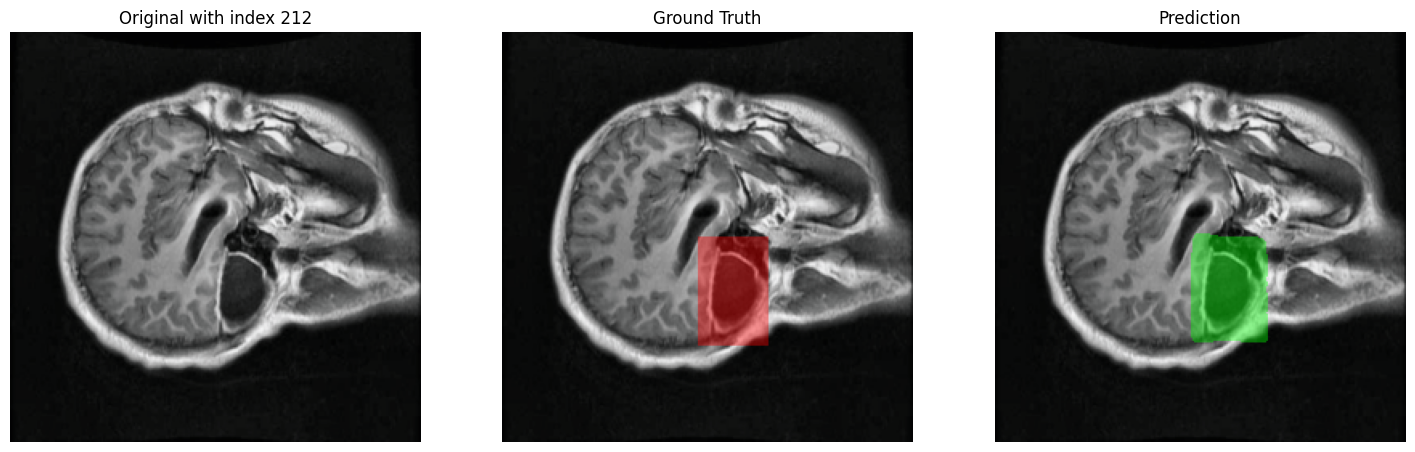

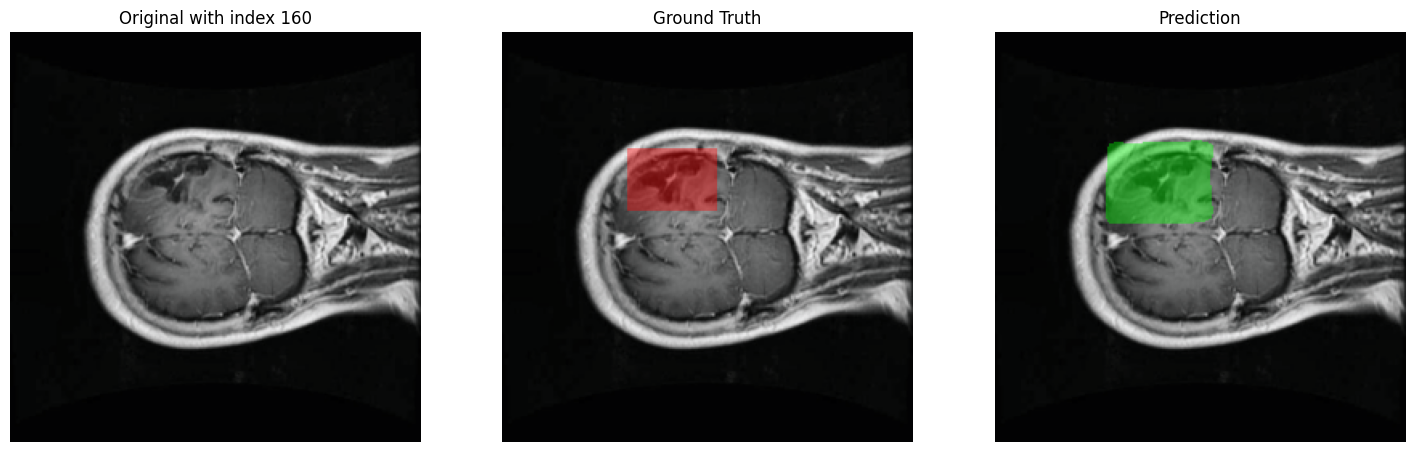

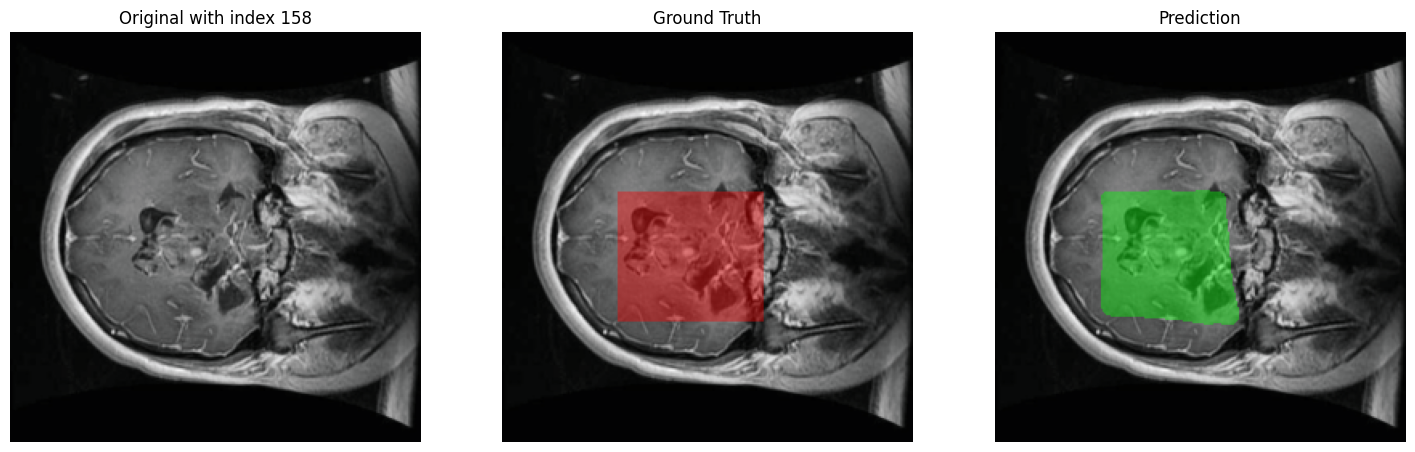

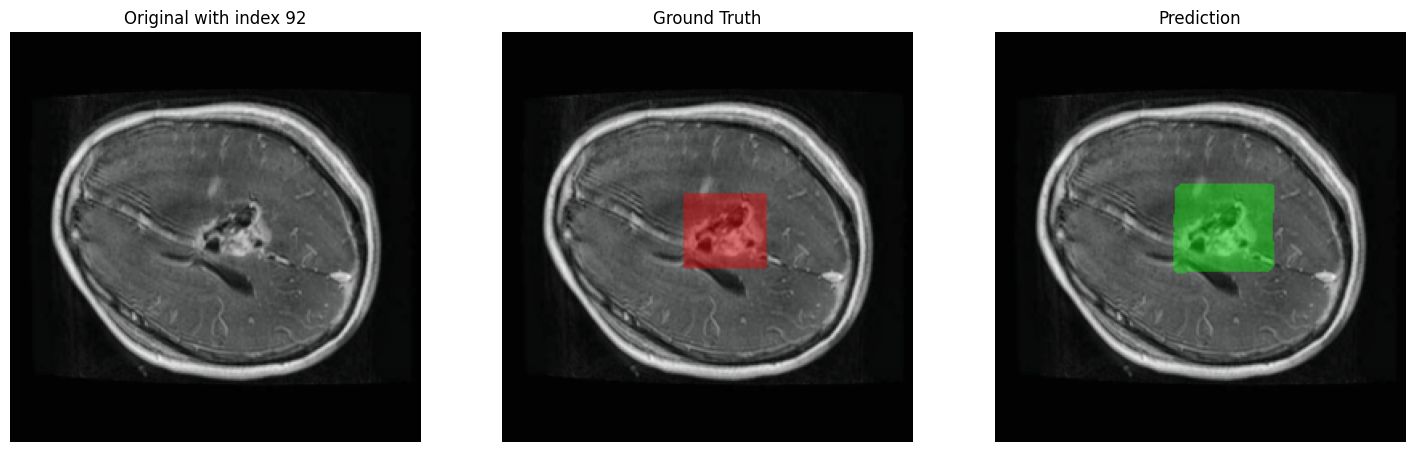

In [56]:
# Show 5 ảnh ground truth và prediction
for _ in range(5):
    show_prediction(model=pretrained_model, dataset=test_dataset)

## Bước 5: Lưu lại ground truth và prediction

In [57]:
for idx in range(0, len(test_dataset) - 1):
    show_prediction(pretrained_model, test_dataset, idx=idx, threshold=0.5, 
                    save_img=True, output_dir="/kaggle/working/output")
print("Save output successfully!")

Save output successfully!
